In [15]:
import pandas as pd

# Custom Libraries for saving excel and transformation of variables
import os
import sys
module_path = os.path.abspath(os.path.join('../../src/utils'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from custom_mmm_modelling import MMM_Modelling
from custom_modelling_plots import ModellingPlots
import pdb
import hyperopt
from hyperopt import fmin, tpe, atpe, hp, STATUS_OK, Trials
from functools import partial

In [16]:
pd.options.display.float_format = '{:20,.5f}'.format

pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', -1)  # or 199

In [17]:
media_dictionary = {'IMP' : 'Impression',
                    'SPEND' : 'Spend',
                    'VIEW_IMP' : 'Viewable Impression',
                    'CLK' : 'Click'}

In [18]:
# User Inputs
target_var = 'O_NEW_CUSTOMER'

# standard names for folders are: new_customer_online, new_customer, sales_unit_online, sales_unit. 
# however the user can choose any folder name
# the folder would be created in models/manual_models
folder_name = 'new_customer'

# standard names for folders are mix_media_metrics, impression, click, spend, viewable_impression
sub_folder = 'mix_media_metrics'

# input files
input_data_path = "../../data/processed_input_data/02_modelling_stack_data_seasonality.csv"

# Loading data dictionary
data_dict = pd.read_excel("../../data/input_data/WMG WAMM Project Data Dictionary_v12.xlsx")


In [19]:
# loading media hierarchy mapping
media_hier_click = pd.read_csv("../../data/input_data/media_hierarchy_CLK.csv")
media_hier_imp = pd.read_csv("../../data/input_data/media_hierarchy_IMP.csv")
media_hier_view_imp = pd.read_csv("../../data/input_data/media_hierarchy_VIEW_IMP.csv")
media_hier_spend = pd.read_csv("../../data/input_data/media_hierarchy_SPEND.csv")

media_hier = pd.concat([media_hier_click, media_hier_imp, media_hier_view_imp, media_hier_spend], axis= 0)


In [20]:
try:
    os.mkdir("../../models/{}/".format('manual'))
except:
    print("manual folder already exists")
    
folder_path = "../../models/manual/{}/".format(folder_name)
try:
    os.mkdir(folder_path)
except:
    print(folder_path + " folder already exists")
    
folder_path += sub_folder + "/"
try:
    os.mkdir(folder_path)
except:
    print(folder_path + " folder already exists")

manual folder already exists
../../models/manual/new_customer/ folder already exists
../../models/manual/new_customer/mix_media_metrics/ folder already exists


In [21]:
#loading data file
df = pd.read_csv(input_data_path, thousands= ",", na_values = " -   ")
df['index'] = pd.to_datetime(df['index']) # Formatting the date
df.set_index("index", inplace = True, drop= False)
df['M_SEARCH_MAN_CLK']=df['M_SBA_CLK']+df['M_SP_KWB_CLK']
df['M_SEARCH_AUTO_CLK']=df['M_SP_AB_CLK']

In [22]:
#Put dummy spends for national media to not break down in built in ROAS calculations
#df['M_NATIONAL_SEARCH_ECOMM_SPEND']=1000
df['M_NATIONAL_TV_SPEND']=1000 
df['M_SEARCH_MAN_SPEND']=df['M_SBA_SPEND']+df['M_SP_KWB_SPEND']
df['M_SEARCH_AUTO_SPEND']=df['M_SP_AB_SPEND']
#df['M_NATIONAL_AUDIO_SPEND']=1000
#df['M_NATIONAL_DISPLAY_ECOMM_SPEND']=1000
#df['M_NATIONAL_SEARCH_SPEND']=1000
#df['M_NATIONAL_DISPLAY_SPEND']=1000
#df['M_NATIONAL_VIDEO_SPEND']=1000

In [23]:
df.columns[df.columns.str.contains('SARIMAX')]

Index(['O_NEW_CUSTOMER_SARIMAX (1, 1, 2) (2, 0, 1, 7)',
       'O_NEW_CUSTOMER_SARIMAX_LOG (1, 1, 1) (2, 0, 2, 7)',
       'O_UNIT_SARIMAX (0, 1, 0) (1, 0, 2, 7)',
       'O_UNIT_SARIMAX_LOG (0, 1, 2) (0, 0, 2, 7)'],
      dtype='object')

In [84]:
# Creating the modelling object
model_obj = MMM_Modelling(df.copy(), target_var, data_dict= data_dict,
                          output_path= folder_path, media_hier= media_hier,
                          comment= 'Media Mix Model')

/Users/m0u00pf/Documents/MMM/GSK Data Extraction/Brand 1 Sensodyne/Modeling without National Media/auto folder_structure/models/manual/new_customer/mix_media_metrics/2021-07-30_model_outputs_v5/01_modelling_details.txt


In [85]:
# Creating train test split
model_obj.create_train_test_split('2019-01-01', '2021-03-31', '2021-04-01', '2021-04-30')

In [86]:
dummy_variables = ['D_HOL_CHRISTMAS','D_HOL_THANKSGIVING','D_HOL_NEW_YEARS_DAY'
                          ,'D_HOL_EASTER','D_HOL_SUPER_BOWL','D_DAY_SATURDAY',
                          'D_EVENT_COVID_LOCKDOWN','D_EVENT_PRE_SUPERBOWL',
                          'D_DAY_SUNDAY',
                   'D_EVENT_COVID_STOCKUP',
                         'D_HOL_LABOR_DAY','D_HOL_MONTHER_DAY','D_HOL_FATHER_DAY',
                         'D_EVENT_PRODUCT_LAUNCH',#'D_EVENT_HOLIDAYS',
                   'D_EVENT_EXTREME_COLD',
                         'INVENTORY_DOTCOM_SELLABLE_ITEMS_TOTAL_QTY',
                   #'PRICE',
                   #'Crest_O_PRICE',
                   #'Colgate_O_PRICE',
                   'PRICE',
                   #'Colgate_MEDIA_SPEND'
                  ]

In [87]:
#Define params space
fspace = {
    'M_ON_DIS_AT_IMP_LAG': hp.quniform('M_ON_DIS_AT_IMP_LAG', 0, 14, 1),
    'M_ON_DIS_CT_ROS_IMP_LAG': hp.quniform('M_ON_DIS_CT_ROS_IMP_LAG', 0, 14, 1),
    'M_ON_DIS_HPLO_IMP_LAG': hp.quniform('M_ON_DIS_HPLO_IMP_LAG', 0, 14, 1),
    'M_ON_DIS_KW_IMP_LAG': hp.quniform('M_ON_DIS_KW_IMP_LAG', 0, 14, 1),
    'M_OFF_DIS_WN_IMP_LAG': hp.quniform('M_OFF_DIS_WN_IMP_LAG', 0, 14, 1), 
        'M_OFF_DIS_SMEDIA_IMP_LAG': hp.quniform('M_OFF_DIS_SMEDIA_IMP_LAG', 0, 14, 1),
    'M_NATIONAL_TV_IMP_LAG': hp.quniform('M_NATIONAL_TV_IMP_LAG', 7, 14, 1), 
    #'M_NATIONAL_AUDIO_IMP_LAG': hp.randint('M_NATIONAL_AUDIO_IMP_LAG', 14), 
    #'M_NATIONAL_DISPLAY_IMP_LAG': hp.randint('M_NATIONAL_DISPLAY_IMP_LAG', 14), 
    #'M_NATIONAL_DISPLAY_ECOMM_IMP_LAG': hp.randint('M_NATIONAL_DISPLAY_ECOMM_IMP_LAG', 14), 
    #'M_NATIONAL_VIDEO_IMP_LAG': hp.randint('M_NATIONAL_VIDEO_IMP_LAG', 14), 
    #'M_SP_AB_CLK_LAG': hp.randint('M_SP_AB_CLK_LAG', 4),
    #'M_SP_KWB_CLK_LAG': hp.randint('M_SP_KWB_CLK_LAG', 4),
    #'M_SBA_CLK_LAG': hp.randint('M_SBA_CLK_LAG', 4),
    'M_SEARCH_AUTO_CLK_LAG': hp.quniform('M_SEARCH_AUTO_CLK_LAG',0,  4, 1),
    'M_SEARCH_MAN_CLK_LAG': hp.quniform('M_SEARCH_MAN_CLK_LAG', 0, 4, 1),
    #'M_NATIONAL_SEARCH_CLK_LAG': hp.randint('M_NATIONAL_SEARCH_CLK_LAG', 4),
    #'M_NATIONAL_SEARCH_ECOMM_CLK_LAG': hp.randint('M_NATIONAL_SEARCH_ECOMM_CLK_LAG', 4),
   
    'M_ON_DIS_AT_IMP_HALF': hp.quniform('M_ON_DIS_AT_IMP_HALF', 0, 8, 1),
    'M_ON_DIS_CT_ROS_IMP_HALF': hp.quniform('M_ON_DIS_CT_ROS_IMP_HALF', 0, 8, 1),
    'M_ON_DIS_HPLO_IMP_HALF': hp.quniform('M_ON_DIS_HPLO_IMP_HALF', 0, 8, 1),
    'M_ON_DIS_KW_IMP_HALF': hp.quniform('M_ON_DIS_KW_IMP_HALF', 0, 8, 1),
    'M_OFF_DIS_WN_IMP_HALF': hp.quniform('M_OFF_DIS_WN_IMP_HALF', 0, 8, 1),
    'M_OFF_DIS_SMEDIA_IMP_HALF': hp.quniform('M_OFF_DIS_SMEDIA_IMP_HALF', 0, 8, 1), 
    'M_NATIONAL_TV_IMP_HALF': hp.quniform('M_NATIONAL_TV_IMP_HALF', 2, 8, 1), 
    #'M_NATIONAL_AUDIO_IMP_HALF': hp.randint('M_NATIONAL_AUDIO_IMP_HALF', 8), 
    #'M_NATIONAL_DISPLAY_IMP_HALF': hp.randint('M_NATIONAL_DISPLAY_IMP_HALF', 8), 
    #'M_NATIONAL_DISPLAY_ECOMM_IMP_HALF': hp.randint('M_NATIONAL_DISPLAY_ECOMM_IMP_HALF', 8), 
    #'M_NATIONAL_VIDEO_IMP_HALF': hp.randint('M_NATIONAL_VIDEO_IMP_HALF', 8), 
    #'M_SP_AB_CLK_HALF': hp.randint('M_SP_AB_CLK_HALF', 4),
    #'M_SP_KWB_CLK_HALF': hp.randint('M_SP_KWB_CLK_HALF', 4),
    #'M_SBA_CLK_HALF': hp.randint('M_SBA_CLK_HALF', 4),
    'M_SEARCH_AUTO_CLK_HALF': hp.quniform('M_SEARCH_AUTO_CLK_HALF', 0, 4, 1),
    'M_SEARCH_MAN_CLK_HALF': hp.quniform('M_SEARCH_MAN_CLK_HALF', 0, 4, 1),
    #'M_NATIONAL_SEARCH_CLK_HALF': hp.randint('M_NATIONAL_SEARCH_CLK_HALF', 4),
    #'M_NATIONAL_SEARCH_ECOMM_CLK_HALF': hp.randint('M_NATIONAL_SEARCH_ECOMM_CLK_HALF', 4),
  
    'M_ON_DIS_AT_IMP_INFLE': hp.quniform('M_ON_DIS_AT_IMP_INFLE', 1, 10, 1),
    'M_ON_DIS_CT_ROS_IMP_INFLE': hp.quniform('M_ON_DIS_CT_ROS_IMP_INFLE', 1, 10, 1),
    'M_ON_DIS_HPLO_IMP_INFLE': hp.quniform('M_ON_DIS_HPLO_IMP_INFLE', 1, 10, 1),
    'M_ON_DIS_KW_IMP_INFLE': hp.quniform('M_ON_DIS_KW_IMP_INFLE', 1, 3, 1),
    'M_OFF_DIS_WN_IMP_INFLE': hp.quniform('M_OFF_DIS_WN_IMP_INFLE', 1, 5, 1), 
    'M_OFF_DIS_SMEDIA_IMP_INFLE': hp.quniform('M_OFF_DIS_SMEDIA_IMP_INFLE', 1, 9, 1), 
    'M_NATIONAL_TV_IMP_INFLE': hp.quniform('M_NATIONAL_TV_IMP_INFLE', 1, 10, 1), 
    #'M_NATIONAL_AUDIO_IMP_INFLE': hp.randint('M_NATIONAL_AUDIO_IMP_INFLE', 10), 
    #'M_NATIONAL_DISPLAY_IMP_INFLE': hp.randint('M_NATIONAL_DISPLAY_IMP_INFLE', 10), 
    #'M_NATIONAL_DISPLAY_ECOMM_IMP_INFLE': hp.randint('M_NATIONAL_DISPLAY_ECOMM_IMP_INFLE', 10), 
    #'M_NATIONAL_VIDEO_IMP_INFLE': hp.randint('M_NATIONAL_VIDEO_IMP_INFLE', 10), 
    #'M_SP_AB_CLK_INFLE': hp.randint('M_SP_AB_CLK_INFLE', 4),
    #'M_SP_KWB_CLK_INFLE': hp.randint('M_SP_KWB_CLK_INFLE', 4),
    #'M_SBA_CLK_INFLE': hp.randint('M_SBA_CLK_INFLE', 4),
    'M_SEARCH_AUTO_CLK_INFLE': hp.quniform('M_SEARCH_AUTO_CLK_INFLE', 1, 4, 1),
    'M_SEARCH_MAN_CLK_INFLE': hp.quniform('M_SEARCH_MAN_CLK_INFLE', 1, 4, 1),
    #'M_NATIONAL_SEARCH_CLK_INFLE': hp.randint('M_NATIONAL_SEARCH_CLK_INFLE', 4),
    #'M_NATIONAL_SEARCH_ECOMM_CLK_INFLE': hp.randint('M_NATIONAL_SEARCH_ECOMM_CLK_INFLE', 4),
  
    'M_ON_DIS_AT_IMP_SCALE': hp.quniform('M_ON_DIS_AT_IMP_SCALE', 1, 12, 1),
    'M_ON_DIS_CT_ROS_IMP_SCALE': hp.quniform('M_ON_DIS_CT_ROS_IMP_SCALE', 1, 12, 1),
    'M_ON_DIS_HPLO_IMP_SCALE': hp.quniform('M_ON_DIS_HPLO_IMP_SCALE', 1, 12, 1),
    'M_ON_DIS_KW_IMP_SCALE': hp.quniform('M_ON_DIS_KW_IMP_SCALE', 1, 5, 1),
    'M_OFF_DIS_WN_IMP_SCALE': hp.quniform('M_OFF_DIS_WN_IMP_SCALE', 1, 9, 1), 
    'M_OFF_DIS_SMEDIA_IMP_SCALE': hp.quniform('M_OFF_DIS_SMEDIA_IMP_SCALE', 1, 12, 1), 
    'M_NATIONAL_TV_IMP_SCALE': hp.quniform('M_NATIONAL_TV_IMP_SCALE', 1, 12, 1), 
    #'M_NATIONAL_AUDIO_IMP_SCALE': hp.randint('M_NATIONAL_AUDIO_IMP_SCALE', 12), 
    #'M_NATIONAL_DISPLAY_IMP_SCALE': hp.randint('M_NATIONAL_DISPLAY_IMP_SCALE', 12), 
    #'M_NATIONAL_DISPLAY_ECOMM_IMP_SCALE': hp.randint('M_NATIONAL_DISPLAY_ECOMM_IMP_SCALE', 12), 
    #'M_NATIONAL_VIDEO_IMP_SCALE': hp.randint('M_NATIONAL_VIDEO_IMP_SCALE', 12), 
    #'M_SP_AB_CLK_SCALE': hp.randint('M_SP_AB_CLK_SCALE', 6),
    #'M_SP_KWB_CLK_SCALE': hp.randint('M_SP_KWB_CLK_SCALE', 6),
    #'M_SBA_CLK_SCALE': hp.randint('M_SBA_CLK_SCALE', 6),
    'M_SEARCH_AUTO_CLK_SCALE': hp.quniform('M_SEARCH_AUTO_CLK_SCALE', 1, 6, 1),
    'M_SEARCH_MAN_CLK_SCALE': hp.quniform('M_SEARCH_MAN_CLK_SCALE', 1, 6, 1),
    #'M_NATIONAL_SEARCH_CLK_SCALE': hp.randint('M_NATIONAL_SEARCH_CLK_SCALE', 6),
    #'M_NATIONAL_SEARCH_ECOMM_CLK_SCALE': hp.randint('M_NATIONAL_SEARCH_ECOMM_CLK_SCALE', 6)
}

In [88]:
#define media list
media_list = ['M_ON_DIS_AT_IMP','M_ON_DIS_CT_ROS_IMP','M_ON_DIS_HPLO_IMP','M_ON_DIS_KW_IMP','M_OFF_DIS_WN_IMP', 'M_OFF_DIS_SMEDIA_IMP','M_NATIONAL_TV_IMP'#, 'M_NATIONAL_AUDIO_IMP','M_NATIONAL_DISPLAY_IMP','M_NATIONAL_DISPLAY_ECOMM_IMP','M_NATIONAL_VIDEO_IMP', 
              #,'M_SP_AB_CLK'
              ,'M_SEARCH_AUTO_CLK','M_SEARCH_MAN_CLK'#'M_SP_KWB_CLK','M_SBA_CLK'#,'M_NATIONAL_SEARCH_CLK','M_NATIONAL_SEARCH_ECOMM_CLK'
             ]
coeff_summary = pd.DataFrame()

In [89]:
#function to evaluate each trial
def f(params):
    media_variables=[]
    for i in media_list:
        var = i+'_LAG'
        lag = params[var]
        var = i+'_HALF'
        half = params[var]
        var = i+'_INFLE'
        infle = params[var]
        var = i+'_SCALE'
        scale  = params[var]
        final_var = i+'_'+str(round(lag,0))+'_'+str(round(half,0))+'_'+str(round(infle,0))+'_'+str(round(scale,0))+'_0'
        media_variables.append(final_var)
    

    other_variables = ['O_NEW_CUSTOMER_SARIMAX (1, 1, 2) (2, 0, 1, 7)']

    # Selecting all the independent variables
    all_independent_variables = dummy_variables + media_variables + other_variables
    model_obj.create_missing_media_transformations(media_variables, trans_start_date= '2019-01-01', trans_end_date= '2020-12-31', reset=True)
    model_obj.create_model_results(X_vars= all_independent_variables, model_type= 'Manual Model 1')


    coeff_summary = model_obj.model_dump['Manual Model 1']['Coefficient Summary'].copy()
    ddf = coeff_summary[coeff_summary['Variables'].str.contains("M_")]
    ddf['p-value'].sum()

    #obj  = -ddf['Coefficient']
    #val  = obj.sum() + ddf['p-value'].sum()

    #set up coefficients. penalize negative coefs and large p values
    neg_coefs = sum(ddf['Coefficient']<0) #ddf[ddf['Coefficient']<0]['Coefficient'].sum()
    pos_coef = ddf[ddf['Coefficient']>=0]['Coefficient'].sum()
    large_p = ddf['p-value'].sum()
    #small_p = 1.0/(ddf[(ddf['Coefficient']<0)&(ddf['p-value']<=0.25)]['p-value'].sum())

    obj = neg_coefs*10000 #- pos_coef*100

    val  = obj + large_p*10 #+ small_p*100
    return {'loss': val, 'status': STATUS_OK}


In [90]:
    #Problematic objective function
    #set up coefficients. penalize negative coefs and large p values
    #neg_coefs = sum(ddf['Coefficient']<0) #ddf[ddf['Coefficient']<0]['Coefficient'].sum()
    #large_p = ddf[(ddf['p-value']>0.25)]['p-value'].sum()
    #small_p = 1.0/(ddf[(ddf['Coefficient']<0)&(ddf['p-value']<=0.25)]['p-value'].sum())
    #obj = neg_coefs*10000 
    #val  = obj + large_p*10 + small_p*100
    
    #The function that works runs without small p.
    #set up coefficients. penalize negative coefs and large p values
    #neg_coefs = sum(ddf['Coefficient']<0) #ddf[ddf['Coefficient']<0]['Coefficient'].sum()
    #large_p = ddf[(ddf['p-value']>0.25)]['p-value'].sum()

    #obj = neg_coefs*10000 

    #val  = obj + large_p*10    

In [91]:
#add best iteration from previous set
points_to_evaluate=[{
 'M_NATIONAL_TV_IMP_HALF': 2.0,
 'M_NATIONAL_TV_IMP_INFLE': 2.0,
 'M_NATIONAL_TV_IMP_LAG': 7.0,
 'M_NATIONAL_TV_IMP_SCALE': 2.0,
 'M_OFF_DIS_SMEDIA_IMP_HALF': 0.0,
 'M_OFF_DIS_SMEDIA_IMP_INFLE': 9.0,
 'M_OFF_DIS_SMEDIA_IMP_LAG': 0.0,
 'M_OFF_DIS_SMEDIA_IMP_SCALE': 8.0,
 'M_OFF_DIS_WN_IMP_HALF': 8.0,
 'M_OFF_DIS_WN_IMP_INFLE': 5.0,
 'M_OFF_DIS_WN_IMP_LAG': 3.0,
 'M_OFF_DIS_WN_IMP_SCALE': 9.0,
 'M_ON_DIS_AT_IMP_HALF': 6.0,
 'M_ON_DIS_AT_IMP_INFLE': 2.0,
 'M_ON_DIS_AT_IMP_LAG': 14.0,
 'M_ON_DIS_AT_IMP_SCALE': 3.0,
 'M_ON_DIS_CT_ROS_IMP_HALF': 0.0,
 'M_ON_DIS_CT_ROS_IMP_INFLE': 6.0,
 'M_ON_DIS_CT_ROS_IMP_LAG': 9.0,
 'M_ON_DIS_CT_ROS_IMP_SCALE': 9.0,
 'M_ON_DIS_HPLO_IMP_HALF': 3.0,
 'M_ON_DIS_HPLO_IMP_INFLE': 10.0,
 'M_ON_DIS_HPLO_IMP_LAG': 1.0,
 'M_ON_DIS_HPLO_IMP_SCALE': 4.0,
 'M_ON_DIS_KW_IMP_HALF': 4.0,
 'M_ON_DIS_KW_IMP_INFLE': 3.0,
 'M_ON_DIS_KW_IMP_LAG': 2.0,
 'M_ON_DIS_KW_IMP_SCALE': 5.0,
 'M_SEARCH_AUTO_CLK_HALF': 4.0,
 'M_SEARCH_AUTO_CLK_INFLE': 2.0,
 'M_SEARCH_AUTO_CLK_LAG': 4.0,
 'M_SEARCH_AUTO_CLK_SCALE': 6.0,
 'M_SEARCH_MAN_CLK_HALF': 3.0,
 'M_SEARCH_MAN_CLK_INFLE': 2.0,
 'M_SEARCH_MAN_CLK_LAG': 4.0,
 'M_SEARCH_MAN_CLK_SCALE': 4.0}]

In [92]:
best = fmin(fn=f, space=fspace, algo=atpe.suggest, max_evals=2000, verbose=True, points_to_evaluate=points_to_evaluate,
            trials_save_file="hyperopt_cust_merged_ctalt2s5_offsplit_output.pkl")
print('best:', best)

2001trial [55:13,  1.66s/trial, best loss: 17.88]                                   
best: {'M_NATIONAL_TV_IMP_HALF': 2.0, 'M_NATIONAL_TV_IMP_INFLE': 2.0, 'M_NATIONAL_TV_IMP_LAG': 7.0, 'M_NATIONAL_TV_IMP_SCALE': 4.0, 'M_OFF_DIS_SMEDIA_IMP_HALF': 0.0, 'M_OFF_DIS_SMEDIA_IMP_INFLE': 9.0, 'M_OFF_DIS_SMEDIA_IMP_LAG': 0.0, 'M_OFF_DIS_SMEDIA_IMP_SCALE': 8.0, 'M_OFF_DIS_WN_IMP_HALF': 8.0, 'M_OFF_DIS_WN_IMP_INFLE': 5.0, 'M_OFF_DIS_WN_IMP_LAG': 3.0, 'M_OFF_DIS_WN_IMP_SCALE': 8.0, 'M_ON_DIS_AT_IMP_HALF': 8.0, 'M_ON_DIS_AT_IMP_INFLE': 2.0, 'M_ON_DIS_AT_IMP_LAG': 14.0, 'M_ON_DIS_AT_IMP_SCALE': 5.0, 'M_ON_DIS_CT_ROS_IMP_HALF': 0.0, 'M_ON_DIS_CT_ROS_IMP_INFLE': 6.0, 'M_ON_DIS_CT_ROS_IMP_LAG': 9.0, 'M_ON_DIS_CT_ROS_IMP_SCALE': 8.0, 'M_ON_DIS_HPLO_IMP_HALF': 4.0, 'M_ON_DIS_HPLO_IMP_INFLE': 10.0, 'M_ON_DIS_HPLO_IMP_LAG': 2.0, 'M_ON_DIS_HPLO_IMP_SCALE': 8.0, 'M_ON_DIS_KW_IMP_HALF': 2.0, 'M_ON_DIS_KW_IMP_INFLE': 3.0, 'M_ON_DIS_KW_IMP_LAG': 3.0, 'M_ON_DIS_KW_IMP_SCALE': 5.0, 'M_SEARCH_AUTO_CLK_HALF': 4.0, 

## Explore the model trials save object, save top trials into a Pandas DataFrame

In [93]:
import pickle
with open("hyperopt_cust_merged_ctalt2s5_offsplit_output.pkl","rb") as trialsfile:
    trials_summary=pickle.load(trialsfile)

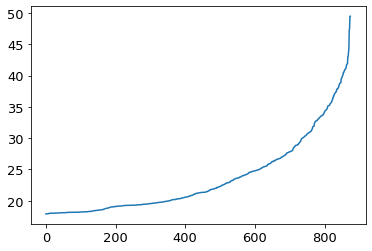

In [107]:
#Plot objective function values from lowest to highest
from matplotlib import pyplot as plt
plt.plot(sorted([trial['result']['loss'] for trial in trials_summary._trials])[0:875]) 
#can play with the range above to find a good cutoff

In [108]:
top_n=875 #your choice
trials_summary_cutoff=sorted([trial['result']['loss'] for trial in trials_summary._trials])[top_n-1]
#get top n objective function values and parameters
trials_summary=[{**{'objective':trial['result']['loss']},
 **{var:val[0] for var,val in trial['misc']['vals'].items()}} 
                            for trial in trials_summary._trials 
                             if trial['result']['loss']<=trials_summary_cutoff]
trials_summary=sorted(trials_summary, key = lambda i: i['objective'])

In [109]:
trials_summary[0]

{'objective': 17.88,
 'M_NATIONAL_TV_IMP_HALF': 2.0,
 'M_NATIONAL_TV_IMP_INFLE': 2.0,
 'M_NATIONAL_TV_IMP_LAG': 7.0,
 'M_NATIONAL_TV_IMP_SCALE': 4.0,
 'M_OFF_DIS_SMEDIA_IMP_HALF': 0.0,
 'M_OFF_DIS_SMEDIA_IMP_INFLE': 9.0,
 'M_OFF_DIS_SMEDIA_IMP_LAG': 0.0,
 'M_OFF_DIS_SMEDIA_IMP_SCALE': 8.0,
 'M_OFF_DIS_WN_IMP_HALF': 8.0,
 'M_OFF_DIS_WN_IMP_INFLE': 5.0,
 'M_OFF_DIS_WN_IMP_LAG': 3.0,
 'M_OFF_DIS_WN_IMP_SCALE': 8.0,
 'M_ON_DIS_AT_IMP_HALF': 8.0,
 'M_ON_DIS_AT_IMP_INFLE': 2.0,
 'M_ON_DIS_AT_IMP_LAG': 14.0,
 'M_ON_DIS_AT_IMP_SCALE': 5.0,
 'M_ON_DIS_CT_ROS_IMP_HALF': 0.0,
 'M_ON_DIS_CT_ROS_IMP_INFLE': 6.0,
 'M_ON_DIS_CT_ROS_IMP_LAG': 9.0,
 'M_ON_DIS_CT_ROS_IMP_SCALE': 8.0,
 'M_ON_DIS_HPLO_IMP_HALF': 4.0,
 'M_ON_DIS_HPLO_IMP_INFLE': 10.0,
 'M_ON_DIS_HPLO_IMP_LAG': 2.0,
 'M_ON_DIS_HPLO_IMP_SCALE': 8.0,
 'M_ON_DIS_KW_IMP_HALF': 2.0,
 'M_ON_DIS_KW_IMP_INFLE': 3.0,
 'M_ON_DIS_KW_IMP_LAG': 3.0,
 'M_ON_DIS_KW_IMP_SCALE': 5.0,
 'M_SEARCH_AUTO_CLK_HALF': 4.0,
 'M_SEARCH_AUTO_CLK_INFLE': 2.0,
 'M_SEARC

In [110]:
#Save all candidate model results in model_obj.model_dump: 1 is already the best.
for ix in range(len(trials_summary)):
    print(ix)
    row=trials_summary[ix]
    media_variables=[]
    for i in media_list:
        var = i+'_LAG'
        lag = row[var]
        var = i+'_HALF'
        half = row[var]
        var = i+'_INFLE'
        infle = row[var]
        var = i+'_SCALE'
        scale  = row[var]
        final_var = i+'_'+str(lag)+'_'+str(half)+'_'+str(infle)+'_'+str(scale)+'_0'
        media_variables.append(final_var)
    other_variables = ['O_NEW_CUSTOMER_SARIMAX (1, 1, 2) (2, 0, 1, 7)']
    # Selecting all the independent variables
    #use media_variables in the modeling notebook
    all_independent_variables = dummy_variables + media_variables + other_variables
    model_obj.create_missing_media_transformations(media_variables, 
                                               trans_start_date= '2019-01-01', trans_end_date= '2020-12-31',reset=True)
    model_obj.create_model_results(X_vars= all_independent_variables, model_type= 'Manual Model '+str(ix+1))
    #Populate coefficients, Annual Contribution and Spend for each media and
    #output into a model selection table
    media_media_final={media:final_var for media,final_var in zip(media_list,media_variables)}
    coef_summary=model_obj.model_dump['Manual Model '+str(ix+1)]['Coefficient Summary']
    contrib_summary=model_obj.model_dump['Manual Model '+str(ix+1)]['ROAS Yearly']
    model_stats_summary=model_obj.model_dump['Manual Model '+str(ix+1)]['Modelling Metrics'].iloc[0:2,]
    #Model performance metrics
    row['MAPE_FIT']=model_stats_summary.iloc[0,0]
    row['MAPE_VALID']=model_stats_summary.iloc[0,1]
    row['RSQ_FIT']=model_stats_summary.iloc[1,0]
    row['RSQ_VALID']=model_stats_summary.iloc[1,1]
    #Non-media coefficients
    nonmedia=[var for var in list(set(coef_summary['Variables'].values.tolist())) if "M_" not in var]  
    for source in nonmedia:
        row[source+'_COEF']=coef_summary[coef_summary['Variables']==source]['Coefficient'].values[0] 
    #Media coefficients
    for media in media_media_final.keys():
        row[media+'_COEF']=coef_summary[coef_summary['Variables']==media_media_final[media]]['Coefficient'].values[0]
        row[media+'_COEFSTD']=coef_summary[coef_summary['Variables']==media_media_final[media]]['Standardized Coefficient'].values[0]
        row[media+'_PVAL']=coef_summary[coef_summary['Variables']==media_media_final[media]]['p-value'].values[0]
        row[media+'_EL']=coef_summary[coef_summary['Variables']==media_media_final[media]]['Elasticity'].values[0]
        row[media+'_RELIMP']=coef_summary[coef_summary['Variables']==media_media_final[media]]['Relative Importance'].values[0]
        row[media+'_VIF']=coef_summary[coef_summary['Variables']==media_media_final[media]]['VIF'].values[0]
        #Media activity by year
        for year in list(set(contrib_summary['Year'].values.tolist())):
            row[media+'_CONTRIB_'+str(year)]=contrib_summary[(contrib_summary['Variable']==media_media_final[media])&(contrib_summary['Year']==year)]['Contribution'].values[0]
            row[media+'_SPEND_'+str(year)]=contrib_summary[(contrib_summary['Variable']==media_media_final[media])&(contrib_summary['Year']==year)]['Spend ($)'].values[0]
            row[media+'_TOTAL_'+str(year)]=model_obj.df[media].groupby(model_obj.df[media].index.year).agg(sum)[year]
            row[media+'_IROAS_'+str(year)]=row[media+'_CONTRIB_'+str(year)]/row[media+'_SPEND_'+str(year)]
trials_summary_out=pd.DataFrame(trials_summary)
trials_summary_out.to_excel(model_obj.output_path+'/Hyperopt_Trials_Cust_Merged_Ctalt2s5_Top'+str(top_n)+'.xlsx')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [123]:
#"Best" Model

#media_variables=[]
#for i in media_list:
#    var = i+'_LAG'
#    lag = best[var]
#    var = i+'_HALF'
#    half = best[var]
#    var = i+'_INFLE'
#    infle = best[var]
#    var = i+'_SCALE'
#    scale  = best[var]
#    final_var = i+'_'+str(lag)+'_'+str(half)+'_'+str(infle)+'_'+str(scale)+'_0'
#    media_variables.append(final_var)

#other_variables = ['O_NEW_CUSTOMER_SARIMAX (1, 1, 2) (2, 0, 1, 7)']

# Selecting all the independent variables
#use media_variables in the modeling notebook
#all_independent_variables = dummy_variables + media_variables + other_variables
#model_obj.create_missing_media_transformations(media_variables, 
#                                               trans_start_date= '2019-01-01', trans_end_date= '2020-12-31')
#model_obj.create_model_results(X_vars= all_independent_variables, model_type= 'Manual Model 1')

#Print best performing model attributes
print(model_obj.model_dump['Manual Model 304']['Coefficient Summary'])

coeff_summary = model_obj.model_dump['Manual Model 304']['Coefficient Summary'].copy()
ddf = coeff_summary[coeff_summary['Variables'].str.contains("M_")]
ddf['p-value'].sum()

#set up coefficients. penalize negative coefs and large p values
neg_coefs = sum(ddf['Coefficient']<0) #ddf[ddf['Coefficient']<0]['Coefficient'].sum()
pos_coef = ddf[ddf['Coefficient']>=0]['Coefficient'].sum()
large_p = ddf['p-value'].sum()
#small_p = 1.0/(ddf[(ddf['Coefficient']<0)&(ddf['p-value']<=0.25)]['p-value'].sum())

obj = neg_coefs*10000 #- pos_coef*100

val  = obj + large_p*10 #+ small_p*100
print(val)

                                        Variables          Coefficient  \
0   INTERCEPT_TERM                                         6,017.21500   
1   D_HOL_CHRISTMAS                                      -12,811.72894   
2   D_HOL_THANKSGIVING                                   -11,517.75333   
3   D_HOL_NEW_YEARS_DAY                                    3,253.75755   
4   D_HOL_EASTER                                          -7,301.50224   
5   D_HOL_SUPER_BOWL                                      -2,976.77774   
6   D_DAY_SATURDAY                                           627.03552   
7   D_EVENT_COVID_LOCKDOWN                                 8,049.05064   
8   D_EVENT_PRE_SUPERBOWL                                  3,705.44766   
9   D_DAY_SUNDAY                                             799.34872   
10  D_EVENT_COVID_STOCKUP                                    665.41787   
11  D_HOL_LABOR_DAY                                        4,326.54879   
12  D_HOL_MONTHER_DAY                 

Variables          Coefficient  \
0   INTERCEPT_TERM                                         6,017.21500   
1   D_HOL_CHRISTMAS                                      -12,811.72894   
2   D_HOL_THANKSGIVING                                   -11,517.75333   
3   D_HOL_NEW_YEARS_DAY                                    3,253.75755   
4   D_HOL_EASTER                                          -7,301.50224   
5   D_HOL_SUPER_BOWL                                      -2,976.77774   
6   D_DAY_SATURDAY                                           627.03552   
7   D_EVENT_COVID_LOCKDOWN                                 8,049.05064   
8   D_EVENT_PRE_SUPERBOWL                                  3,705.44766   
9   D_DAY_SUNDAY                                             799.34872   
10  D_EVENT_COVID_STOCKUP                                    665.41787   
11  D_HOL_LABOR_DAY                                        4,326.54879   
12  D_HOL_MONTHER_DAY                                     -4,718.47666   
13  D_HOL_FATHER_DAY                                      -3,715.59678   
14  D_EVENT_PRODUCT_LAUNCH                                   664.05920   
15  D_EVENT_EXTREME_COLD                                  -2,792.04907   
16  INVENTORY_DOTCOM_SELLABLE_ITEMS_TOTAL_QTY                  0.02008   
17  PRICE                                                   -758.49076   
18  M_ON_DIS_AT_IMP_14.0_8.0_2.0_4.0_0                         0.00049   
19  M_ON_DIS_CT_ROS_IMP_9.0_0.0_6.0_7.0_0                      0.00010   
20  M_ON_DIS_HPLO_IMP_1.0_3.0_10.0_7.0_0                       0.00069   
21  M_ON_DIS_KW_IMP_3.0_2.0_3.0_5.0_0                          0.00730   
22  M_OFF_DIS_WN_IMP_3.0_8.0_5.0_9.0_0                         0.00005   
23  M_OFF_DIS_SMEDIA_IMP_0.0_0.0_9.0_8.0_0                     0.00024   
24  M_NATIONAL_TV_IMP_7.0_2.0_2.0_2.0_0                        2.29162   
25  M_SEARCH_AUTO_CLK_4.0_4.0_2.0_6.0_0                        0.05320   
26  M_SEARCH_MAN_CLK_4.0_3.0_2.0_4.0_0                         0.21733   
27  O_NEW_CUSTOMER_SARIMAX (1, 1, 2) (2, 0, 1, 7)              0.86584   

             Elasticity    Custom Elasticity  Incremental Impact  
0               0.00000              0.00000  0                   
1              -0.00153              0.00000  0                   
2              -0.00138              0.00000  0                   
3               0.00058              0.00000  0                   
4              -0.00131              0.00000  0                   
5              -0.00053              0.00000  0                   
6               0.00454              0.00000  0                   
7               0.00048              0.00000  0                   
8               0.00066              0.00000  0                   
9               0.00578              0.00000  0                   
10              0.00084              0.00000  0                   
11              0.00052              0.00000  0                   
12             -0.00056              0.00000  0                   
13             -0.00044              0.00000  0                   
14              0.00338              0.00000  0                   
15             -0.00050              0.00000  0                   
16              0.03291              0.00000  0                   
17             -0.23820              0.00000  0                   
18              0.00566              0.00071  93414               
19              0.00034              0.00010  5773                
20              0.00194              0.00063  32048               
21              0.00202              0.00574  33822               
22              0.00022              0.00003  3604                
23              0.00029              0.00023  5725                
24              0.00561              2.33561  93867               
25              0.00237              0.06011  39580               
26              0.00241              0.20068  40231               
27              0

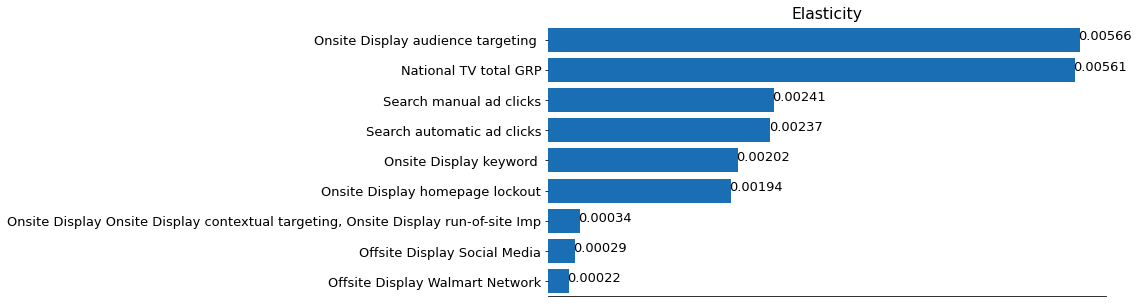

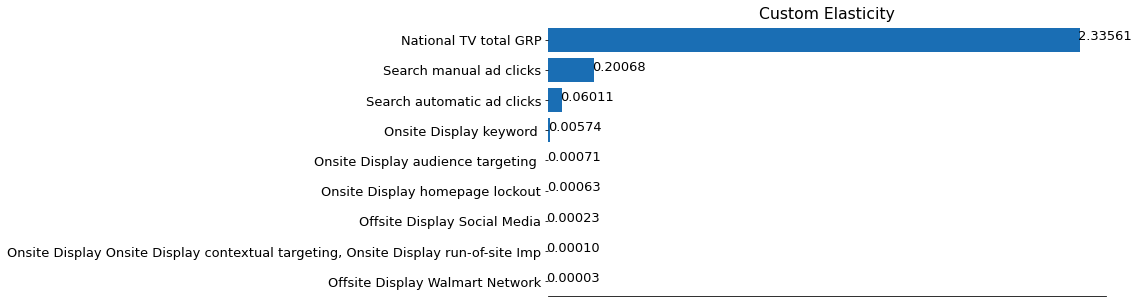

In [124]:
model_obj.data_dict=data_dict
all_vars = list(model_obj.model_dump['Manual Model 304']['Coefficient Summary'].Variables).copy()
media_vars = [col for col in all_vars if col.startswith('M_')]
model_obj.create_missing_media_transformations(media_vars, 
                                               trans_start_date= '2019-01-01', trans_end_date= '2020-12-31')
all_indep_vars=[var for var in all_vars if var!='INTERCEPT_TERM']
model_obj.create_model_results(X_vars= all_indep_vars, model_type= 'Manual Model 304')
model_obj.visualize_model_custom_period(all_indep_vars, 
                                       start_date= '2019-01-01', end_date= '2021-04-30')

In [125]:
# Import the necessaries libraries
import plotly.offline as pyo
import plotly.graph_objs as go
# Set notebook mode to work in offline
pyo.init_notebook_mode()

In [126]:
model_obj.visualize_model_outputs('Manual Model 304', contribution_graph= True, add_residual= True, separate_validation= True,
                                  analyst_review= True, show_yaxis= True,
                                  )

Display Level  \
0   Onsite Display keyword                                                               
1   National TV total GRP                                                                
2   Search manual ad clicks                                                              
3   Onsite Display homepage lockout                                                      
4   Onsite Display audience targeting                                                    
5   Search automatic ad clicks                                                           
6   Offsite Display Social Media                                                         
7   Onsite Display Onsite Display contextual targeting, Onsite Display run-of-site Imp   
8   Offsite Display Walmart Network                                                      
9   Total Incremental                                                                    
10  Base                                                                                 
11  Total                                                                                

    Contribution Share (%) Total Contribution Total Sales ($) Total Spend ($)  \
0  9.7                      33,822             620,732         97,333           
1  27.0                     93,867             1,722,701       851,000          
2  11.6                     40,231             738,350         388,179          
3  9.2                      32,048             588,167         318,577          
4  26.8                     93,414             1,714,391       1,534,639        
5  11.4                     39,580             726,406         965,328          
6  1.6                      5,725              105,071         157,539          
7  1.7                      5,773              105,959         530,842          
8  1.0                      3,604              66,145          763,651          
9  2.1                      348,065            6,387,922       5,607,089        
10 97.9                     16,371,302         300,456,925     0                
11 100.0                    16,719,367         306,844,848     5,607,089        

    Spend Share (%)    Raw Media  Raw Media Share (%)  NCoAS  Value NCoAS ($)  
0  1.7               5,896,452   1.5                  34.75  637.74            
1  15.2              40,189      0.0                  11.03  202.43            
2  6.9               200,473     0.1                  10.36  190.21            
3  5.7               50,594,663  13.1                 10.06  184.62            
4  27.4              131,884,439 34.1                 6.09   111.71            
5  17.2              658,445     0.2                  4.1    75.25             
6  2.8               25,081,967  6.5                  3.63   66.7              
7  9.5               59,525,879  15.4                 1.09   19.96             
8  13.6              112,932,502 29.2                 0.47   8.66              
9  100.0             386,815,009 100.0                6.21   113.93            
10 0.0               0           0.0                  0.0    0.0               
11 0.0               386,815,009 0.0                  0.0    0.0